# APRAU — Step 1 (2025/26)
**Notebook gerado automaticamente (2025-10-23 21:32)**  
Grupo: *group_21.csv*

Este notebook cumpre o enunciado:
- EDA (estatísticas, univariada, bivariada)
- Regressão (simples e múltipla) para `target_regression`
- Classificação (LogReg, LDA, QDA) com Holdout, K-Fold (k=5,10), LOOCV e Bootstrap
- Seleção de *features* com regularização (para classificação)
- Tabelas e gráficos com **matplotlib** (sem seaborn), um gráfico por *figure* e cores por defeito.


### Como usar
Execute as células de cima para baixo. Todas as dependências usadas são do `scikit-learn` e `matplotlib`.

In [1]:

# === Setup ===
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold, LeaveOneOut
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Regression
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV

# Classification
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA, QuadraticDiscriminantAnalysis as QDA

# Feature selection
from sklearn.feature_selection import SelectFromModel

# Metrics
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report

import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = (8, 5)
plt.rcParams['axes.grid'] = True

DATA_PATH = "group_21.csv"
df = pd.read_csv(DATA_PATH)
print("Rows, Cols:", df.shape)
df.head(3)


Rows, Cols: (2999, 49)


,duration_1,duration_2,duration_3,duration_4,duration_5,loudness_level,popularity_level,tempo_class,time_signature,key_mode,...,is_instrumental,is_dance_hit,temp_zscore,resonance_factor,timbre_index,echo_constant,distorted_movement,signal_power,target_class,target_regression
0,0.0,0.0,1.0,0.0,0.0,3.0,0.0,1.0,-2.089669,-0.076786,...,0.0,0.0,-0.738124,2.414248,0.914540,1,0.640763,0.996,class_50,1.423957
1,0.0,0.0,0.0,1.0,0.0,0.0,3.0,0.0,-2.089669,-0.667708,...,0.0,0.0,2.300475,-0.636563,0.335506,1,0.387222,0.919,class_50,0.751458
2,0.0,1.0,0.0,0.0,0.0,3.0,2.0,1.0,0.221824,-0.386317,...,0.0,0.0,1.097571,0.543859,0.297147,1,-0.805572,0.869,class_50,1.244624


## 1) EDA — Análise Exploratória
Inclui estatísticas descritivas, análise univariada e bivariada.  
**Nota:** O código é robusto a diferentes esquemas, detetando automaticamente colunas numéricas e categóricas (incluindo `target_class` e `target_regression`).

In [2]:

# Detectar colunas-alvo e tipo de variáveis
target_reg = 'target_regression' if 'target_regression' in df.columns else None
target_cls = 'target_class' if 'target_class' in df.columns else None

num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in df.columns if c not in num_cols]

# Remover alvos das listas de features
for t in [target_reg, target_cls]:
    if t in num_cols: num_cols.remove(t)
    if t in cat_cols: cat_cols.remove(t)

print("Alvo regressão:", target_reg)
print("Alvo classificação:", target_cls)
print("Numéricas (sample):", num_cols[:10])
print("Categóricas (sample):", cat_cols[:10])

display(df.head(10))


Alvo regressão: target_regression
Alvo classificação: target_class
Numéricas (sample): ['duration_1', 'duration_2', 'duration_3', 'duration_4', 'duration_5', 'loudness_level', 'popularity_level', 'tempo_class', 'time_signature', 'key_mode']
Categóricas (sample): ['focus_factor']


,duration_1,duration_2,duration_3,duration_4,duration_5,loudness_level,popularity_level,tempo_class,time_signature,key_mode,...,is_instrumental,is_dance_hit,temp_zscore,resonance_factor,timbre_index,echo_constant,distorted_movement,signal_power,target_class,target_regression
0,0.0,0.0,1.0,0.0,0.0,3.0,0.0,1.0,-2.089669,-0.076786,...,0.0,0.0,-0.738124,2.414248,0.914540,1,0.640763,0.996,class_50,1.423957
1,0.0,0.0,0.0,1.0,0.0,0.0,3.0,0.0,-2.089669,-0.667708,...,0.0,0.0,2.300475,-0.636563,0.335506,1,0.387222,0.919,class_50,0.751458
2,0.0,1.0,0.0,0.0,0.0,3.0,2.0,1.0,0.221824,-0.386317,...,0.0,0.0,1.097571,0.543859,0.297147,1,-0.805572,0.869,class_50,1.244624
3,0.0,0.0,1.0,0.0,0.0,3.0,0.0,1.0,0.221824,1.020640,...,0.0,0.0,1.096637,0.926744,0.917044,1,1.303427,0.941,class_50,1.379124
4,0.0,0.0,1.0,0.0,0.0,3.0,0.0,1.0,0.221824,-0.076786,...,0.0,0.0,0.917474,0.101183,0.970789,1,0.485181,0.861,class_50,1.648124
5,0.0,0.0,1.0,0.0,0.0,1.0,3.0,1.0,0.221824,1.611562,...,0.0,0.0,0.988792,1.385828,0.280967,1,-0.880482,0.705,class_50,0.213459
6,0.0,1.0,0.0,0.0,0.0,3.0,2.0,1.0,0.221824,1.583423,...,0.0,0.0,1.096604,1.995213,0.891087,1,-0.459835,0.967,class_50,1.020458
7,0.0,0.0,0.0,1.0,0.0,3.0,0.0,1.0,0.221824,1.020640,...,0.0,0.0,0.926848,-1.109612,0.389883,1,-0.598130,0.948,class_50,1.423957
8,0.0,0.0,1.0,0.0,0.0,1.0,2.0,1.0,0.221824,-0.920961,...,0.0,0.0,0.925980,0.116146,0.636474,1,0.076059,0.594,class_50,1.065291
9,0.0,0.0,1.0,0.0,0.0,3.0,0.0,1.0,0.221824,1.020640,...,0.0,0.0,0.930784,0.915677,0.916762,1,0.709911,0.940,class_50,1.423957


In [3]:

# Estatísticas descritivas
desc_num = df[num_cols].describe().T if len(num_cols) else pd.DataFrame()
desc_cat = df[cat_cols].describe().T if len(cat_cols) else pd.DataFrame()

print("=== Estatísticas Numéricas ===")
display(desc_num)

print("=== Estatísticas Categóricas ===")
display(desc_cat)

# Valores em falta
missing = df.isna().sum().sort_values(ascending=False)
print("=== Missing values ===")
display(missing[missing>0])


=== Estatísticas Numéricas ===


,count,mean,std,min,25%,50%,75%,max
duration_1,2999.0,0.142381,0.349499,0.000000,0.000000,0.000000e+00,0.000000,1.000000
duration_2,2999.0,0.236412,0.424949,0.000000,0.000000,0.000000e+00,0.000000,1.000000
duration_3,2999.0,0.303101,0.459675,0.000000,0.000000,0.000000e+00,1.000000,1.000000
duration_4,2999.0,0.286429,0.452168,0.000000,0.000000,0.000000e+00,1.000000,1.000000
duration_5,2999.0,0.031677,0.175169,0.000000,0.000000,0.000000e+00,0.000000,1.000000
loudness_level,2999.0,1.892964,1.346634,0.000000,1.000000,2.000000e+00,3.000000,4.000000
popularity_level,2999.0,1.918973,1.083152,0.000000,1.000000,2.000000e+00,3.000000,4.000000
tempo_class,2999.0,1.067689,0.335402,0.000000,1.000000,1.000000e+00,1.000000,4.000000
time_signature,2999.0,-0.017110,0.942046,-9.024149,0.221824,2.218242e-01,0.221824,2.533318
key_mode,2999.0,0.027457,1.025497,-1.511882,-0.920961,1.764658e-01,1.020640,1.611562


=== Estatísticas Categóricas ===


,count,unique,top,freq
focus_factor,2999,1402,0.0,1108


=== Missing values ===


,0


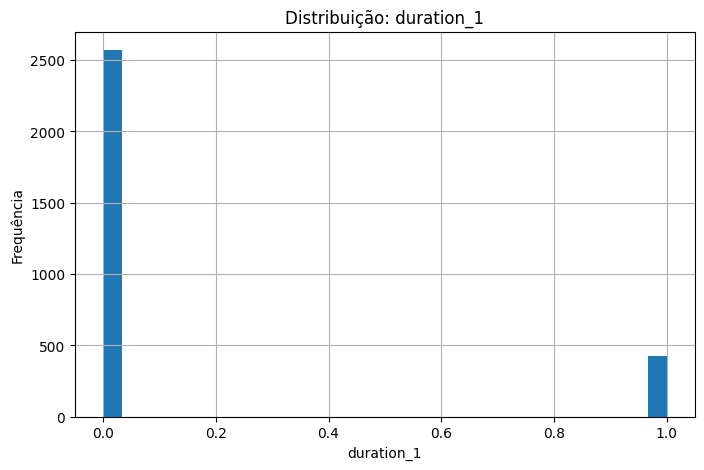

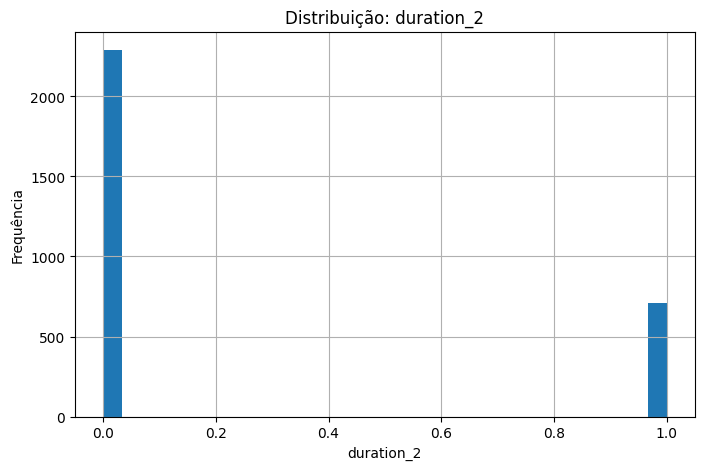

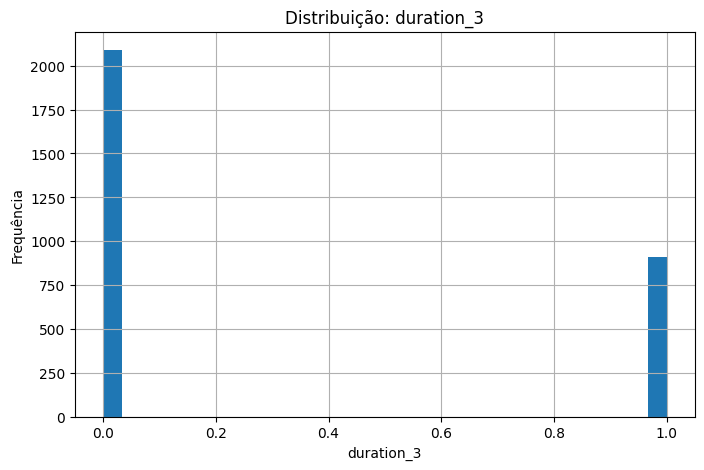

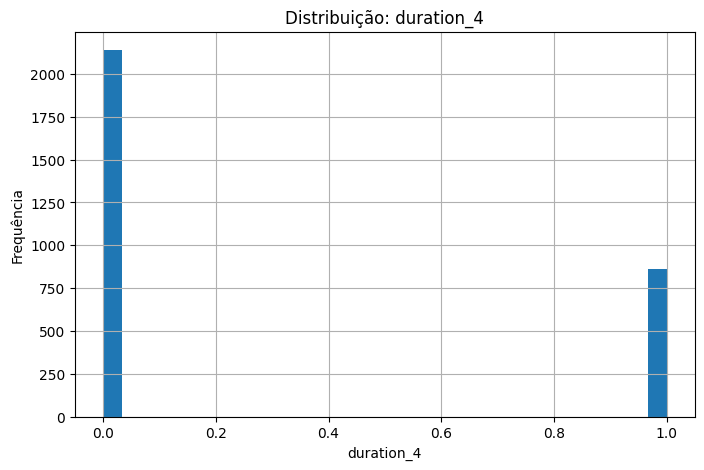

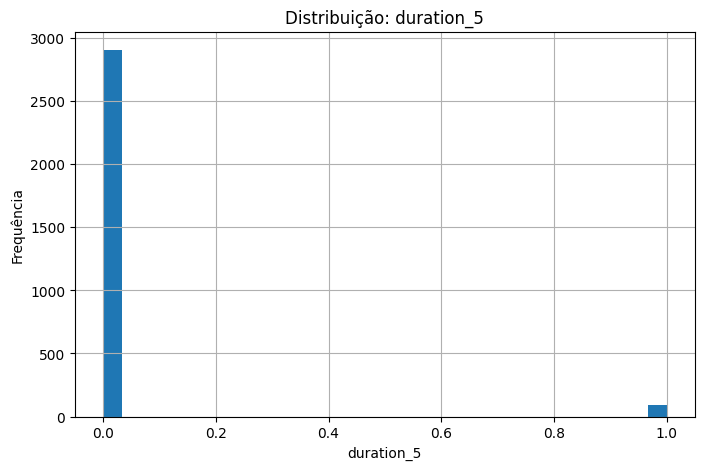

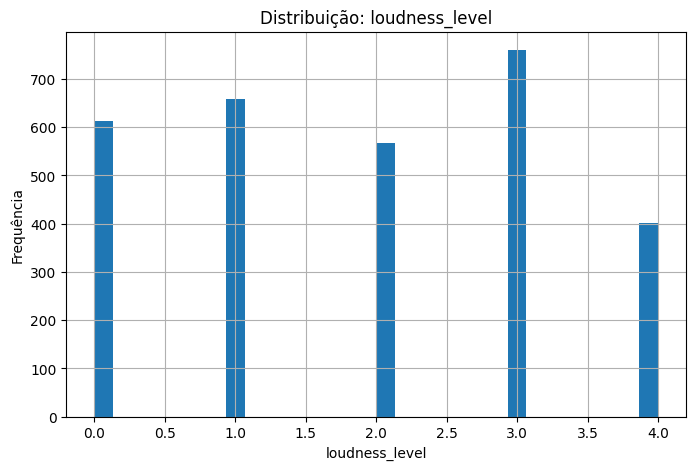

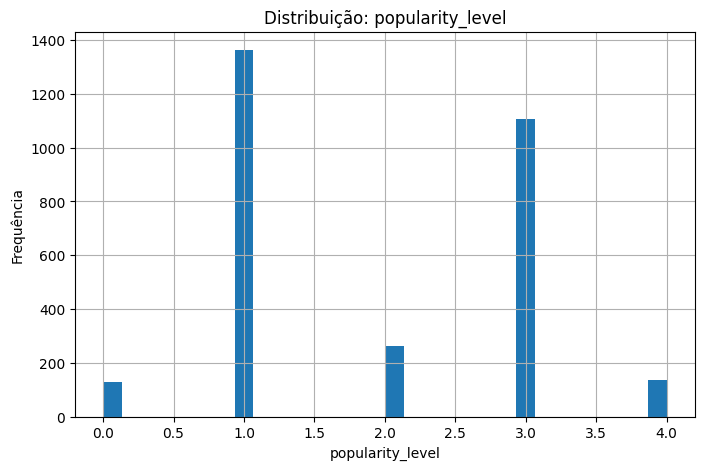

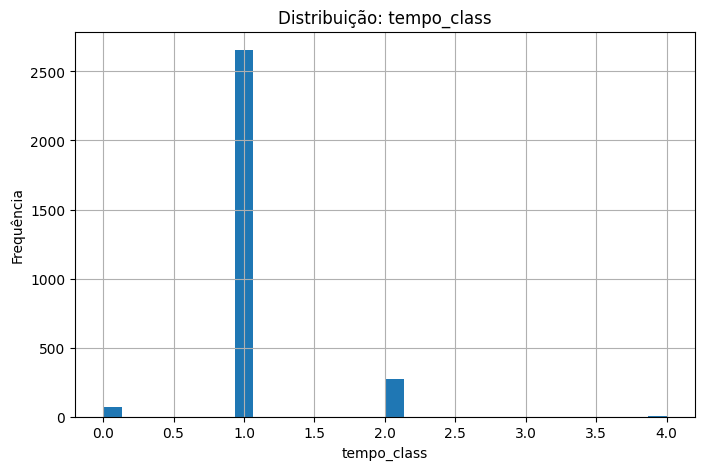

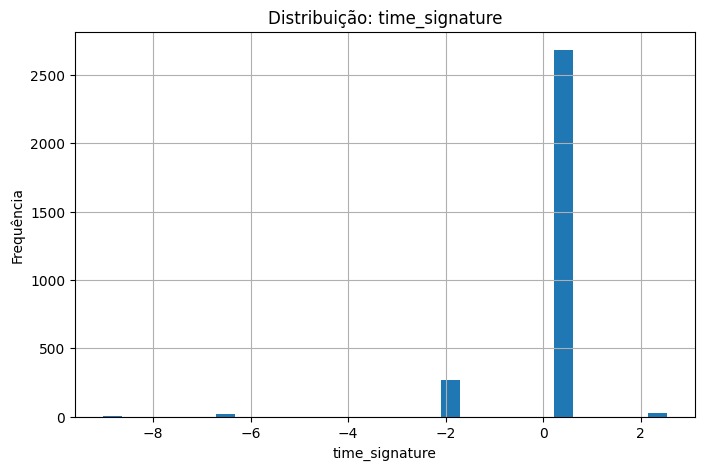

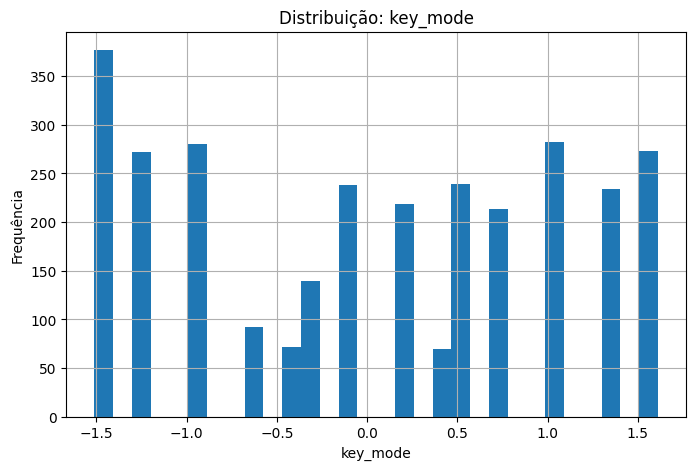

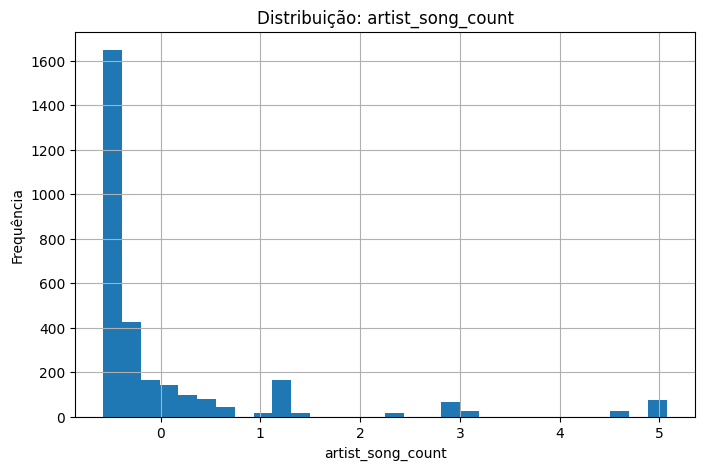

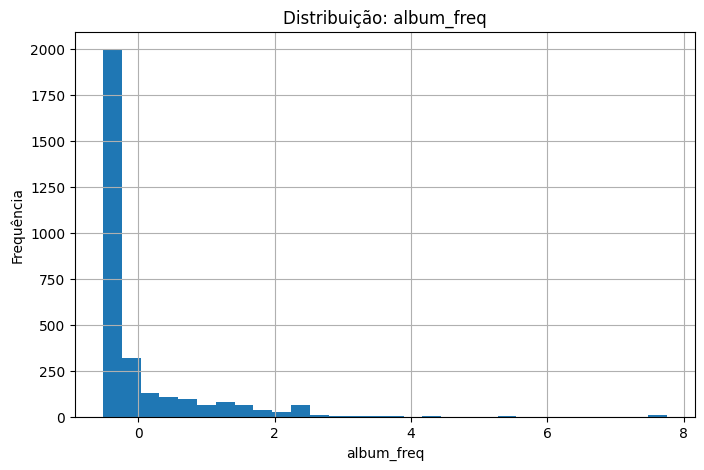

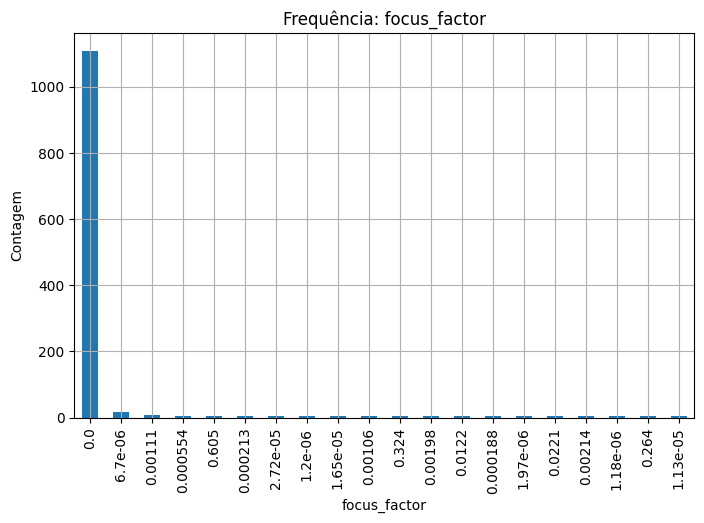

In [4]:

# Univariada: histogramas para numéricas (até 12 primeiras para evitar excesso)
plot_cols = num_cols[:12]
for c in plot_cols:
    plt.figure()
    plt.hist(df[c].dropna(), bins=30)
    plt.title(f"Distribuição: {c}")
    plt.xlabel(c); plt.ylabel("Frequência")
    plt.show()

# Categóricas: barras (até 8 primeiras)
plot_cats = cat_cols[:8]
for c in plot_cats:
    vc = df[c].value_counts().head(20)
    plt.figure()
    vc.plot(kind='bar')
    plt.title(f"Frequência: {c}")
    plt.xlabel(c); plt.ylabel("Contagem")
    plt.show()


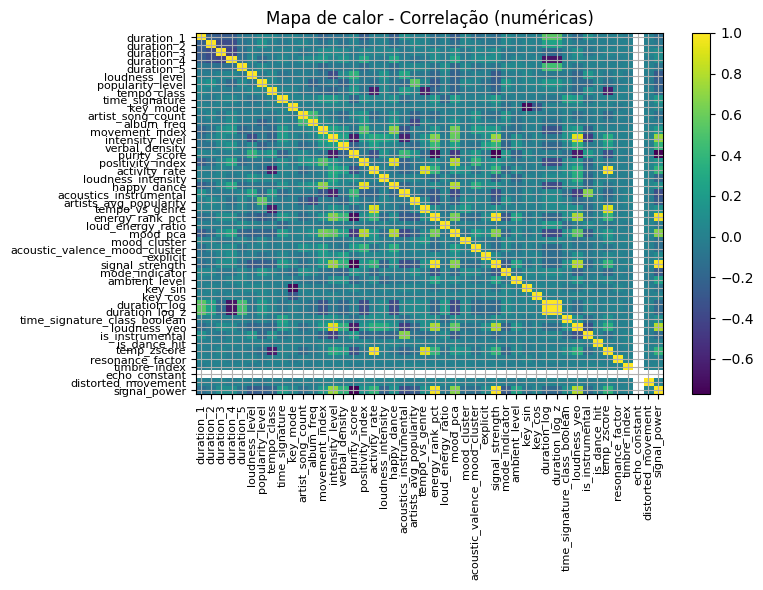

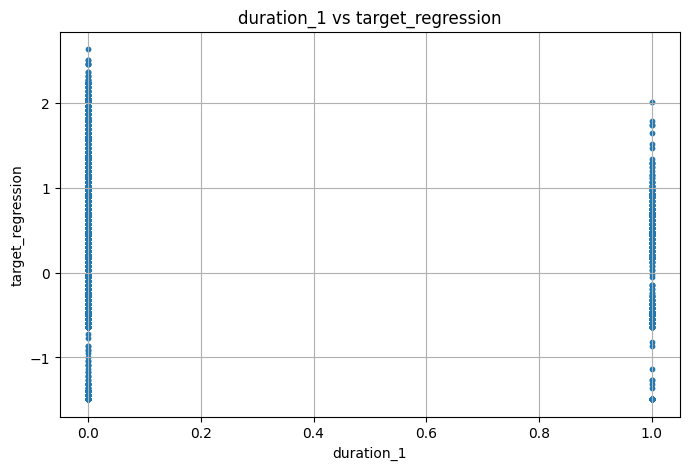

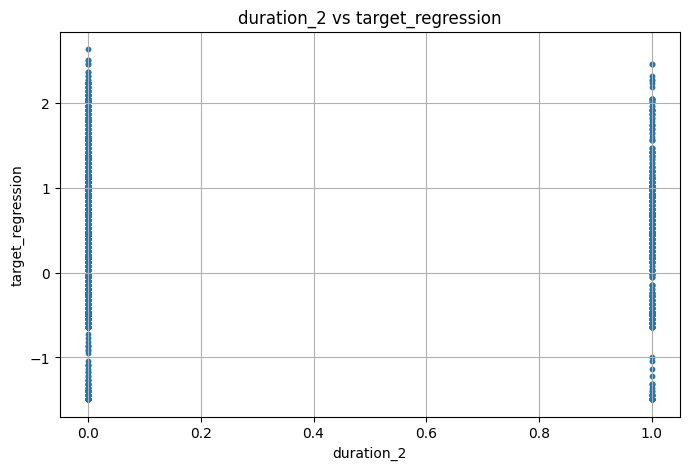

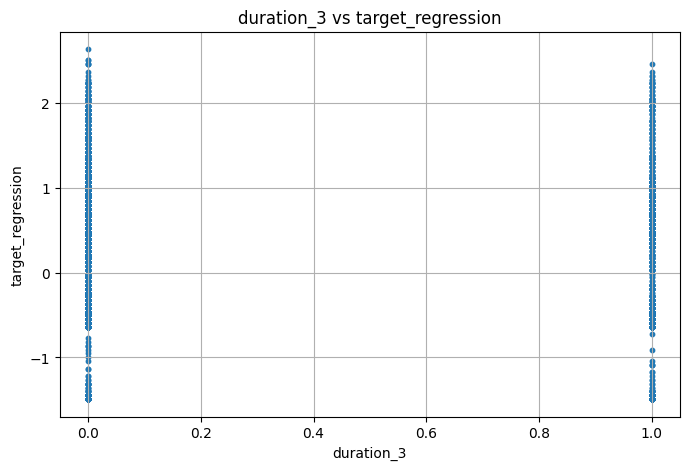

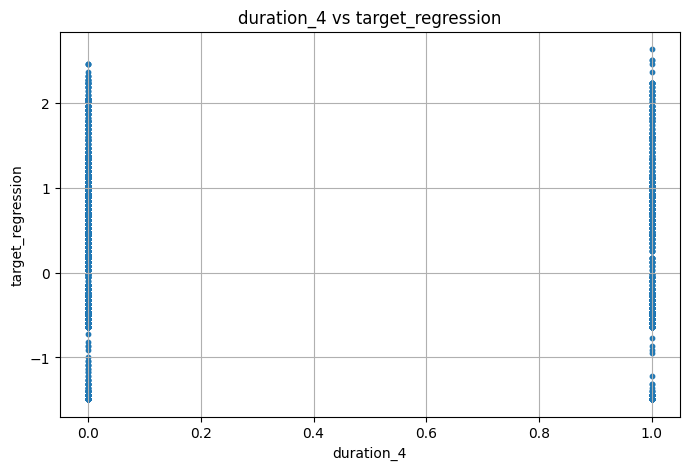

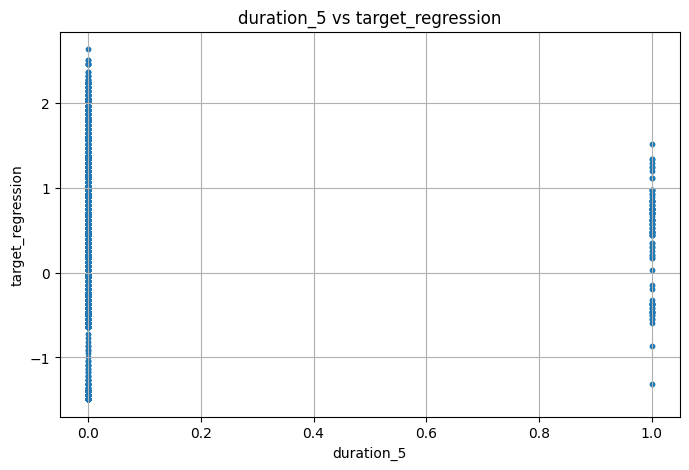

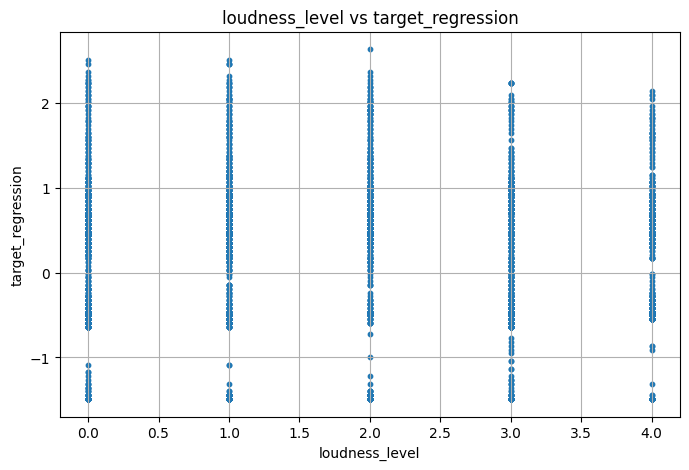

In [5]:

# Bivariada: correlação entre numéricas
if len(num_cols) >= 2:
    corr = df[num_cols].corr(numeric_only=True)
    plt.figure(figsize=(8,6))
    plt.imshow(corr, aspect='auto')
    plt.title("Mapa de calor - Correlação (numéricas)")
    plt.colorbar()
    plt.xticks(range(len(num_cols)), num_cols, rotation=90, fontsize=8)
    plt.yticks(range(len(num_cols)), num_cols, fontsize=8)
    plt.tight_layout()
    plt.show()

# Relação feature numérica vs target_regression (scatter)
if 'target_regression' in df.columns:
    plot_cols = num_cols[:6]
    for c in plot_cols:
        plt.figure()
        plt.scatter(df[c], df['target_regression'], s=10)
        plt.title(f"{c} vs target_regression")
        plt.xlabel(c); plt.ylabel("target_regression")
        plt.show()


## 2) Regressão — Simple & Multiple Linear Regression
- **Simple:** testa cada *feature* numérica isoladamente e escolhe a melhor no *holdout*.
- **Multiple:** usa *pipeline* com `OneHotEncoder` (categóricas) + `StandardScaler` (numéricas) + `LinearRegression`.
Métricas: R², MAE, RMSE (holdout).

In [7]:
if 'target_regression' in df.columns:
    # Holdout split
    features = [c for c in df.columns if c != 'target_regression']
    X = df[features].copy()
    y = df['target_regression'].values

    # Detect types again locally
    X_num = X.select_dtypes(include=[np.number]).columns.tolist()
    X_cat = [c for c in X.columns if c not in X_num]

    # Simple Linear Regression: testar cada numérica
    best_feature = None
    best_r2 = -np.inf
    results_simple = []

    for feat in X_num:
        Xi = X[[feat]].copy()
        # Simple imput
        Xi_train, Xi_test, y_train, y_test = train_test_split(Xi, y, test_size=0.2, random_state=42)
        pipe = Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler()),
            ('linreg', LinearRegression())
        ])
        pipe.fit(Xi_train, y_train)
        y_pred = pipe.predict(Xi_test)
        r2 = r2_score(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        rmse = mean_squared_error(y_test, y_pred) ** 0.5  # <--- corrigido aqui
        results_simple.append((feat, r2, mae, rmse))
        if r2 > best_r2:
            best_r2 = r2
            best_feature = feat

    results_simple_df = pd.DataFrame(results_simple, columns=['feature','R2','MAE','RMSE']).sort_values('R2', ascending=False)
    print("=== Simple Linear Regression — Top 10 ===")
    display(results_simple_df.head(10))
    print(f"Melhor *feature*: {best_feature}  |  R²={best_r2:.4f}")

    # Multiple Linear Regression: todas as features (num + cat)
    preprocessor = ColumnTransformer([
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), X_num),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ]), X_cat)
    ])

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    pipe_multi = Pipeline([
        ('prep', preprocessor),
        ('linreg', LinearRegression())
    ])

    pipe_multi.fit(X_train, y_train)
    y_pred = pipe_multi.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred) ** 0.5  # <--- corrigido aqui também

    print("=== Multiple Linear Regression (holdout) ===")
    print(f"R²={r2:.4f} | MAE={mae:.4f} | RMSE={rmse:.4f}")
else:
    print("Coluna 'target_regression' não encontrada no dataset.")


=== Simple Linear Regression — Top 10 ===


,feature,R2,MAE,RMSE
21,artists_avg_popularity,0.745367,0.261306,0.481198
6,popularity_level,0.409337,0.501157,0.732886
11,album_freq,0.208148,0.702336,0.848572
23,energy_rank_pct,0.056875,0.725197,0.926086
45,signal_power,0.044373,0.745114,0.932204
29,signal_strength,0.044373,0.745114,0.932204
10,artist_song_count,0.038494,0.793418,0.935067
25,mood_pca,0.030446,0.769529,0.938973
14,verbal_density,0.026404,0.766457,0.940928
30,mode_indicator,0.018779,0.780993,0.944605


Melhor *feature*: artists_avg_popularity  |  R²=0.7454
=== Multiple Linear Regression (holdout) ===
R²=0.7573 | MAE=0.3057 | RMSE=0.4698


## 3) Classificação — LogReg, LDA, QDA
Resampling avaliado em: **Holdout, k=5, k=10, LOOCV e Bootstrap**.  
Métricas principais: **Accuracy** e **F1-macro** (classes desequilibradas).

In [ ]:

def eval_holdout(pipe, X, y, stratify=True):
    if stratify:
        X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    else:
        X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, random_state=42)

    pipe.fit(X_tr, y_tr)
    y_pred = pipe.predict(X_te)
    acc = accuracy_score(y_te, y_pred)
    f1m = f1_score(y_te, y_pred, average='macro')
    return acc, f1m, classification_report(y_te, y_pred, zero_division=0)

def eval_cv(pipe, X, y, k=5):
    cv = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    acc = cross_val_score(pipe, X, y, cv=cv, scoring='accuracy')
    f1m = cross_val_score(pipe, X, y, cv=cv, scoring='f1_macro')
    return acc.mean(), f1m.mean()

def eval_loocv(pipe, X, y, max_n=600):
    n = X.shape[0]
    if n > max_n:
        # Para não demorar demasiado, usamos uma amostra estratificada até max_n
        from sklearn.model_selection import StratifiedShuffleSplit
        sss = StratifiedShuffleSplit(n_splits=1, test_size=n-max_n, random_state=42)
        idx = np.arange(n)
        for tr_idx, te_idx in sss.split(X, y):
            subset_idx = tr_idx  # pegar o maior split (~max_n)
            break
        X_ = X.iloc[subset_idx] if hasattr(X, 'iloc') else X[subset_idx]
        y_ = y[subset_idx]
        print(f"LOOCV em amostra estratificada de {X_.shape[0]} (de {n}) para acelerar.")
    else:
        X_, y_ = X, y

    loo = LeaveOneOut()
    accs, f1s = [], []
    i = 0
    for tr, te in loo.split(np.arange(len(y_))):
        i += 1
        pipe.fit(X_.iloc[tr], y_[tr])       # <--- CORRIGIDO
        y_pred = pipe.predict(X_.iloc[te])  # <--- CORRIGIDO
        accs.append(accuracy_score(y_[te], y_pred))
        f1s.append(f1_score(y_[te], y_pred, average='macro', zero_division=0))
        if i % 200 == 0:
            print(f"LOOCV progress: {i}/{len(y_)}")
    return np.mean(accs), np.mean(f1s)


def eval_bootstrap(pipe, X, y, B=200):
    rng = np.random.RandomState(42)
    accs, f1s = [], []
    n = len(y)
    for b in range(B):
        idx = rng.randint(0, n, n)
        oob = np.setdiff1d(np.arange(n), idx)
        if len(oob) == 0:
            continue
        pipe.fit(X.iloc[idx] if hasattr(X, 'iloc') else X[idx], y[idx])
        yp = pipe.predict(X.iloc[oob] if hasattr(X, 'iloc') else X[oob])
        accs.append(accuracy_score(y[oob], yp))
        f1s.append(f1_score(y[oob], yp, average='macro', zero_division=0))
    return np.mean(accs), np.mean(f1s)

if 'target_class' in df.columns:
    features = [c for c in df.columns if c != 'target_class']
    X = df[features].copy()
    y = df['target_class'].values

    X_num = X.select_dtypes(include=[np.number]).columns.tolist()
    X_cat = [c for c in X.columns if c not in X_num]

    preprocessor = ColumnTransformer([
      ('num', Pipeline([
          ('imputer', SimpleImputer(strategy='median')),
          ('scaler', StandardScaler())
      ]), X_num),
      ('cat', Pipeline([
          ('imputer', SimpleImputer(strategy='most_frequent')),
          ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))  # <--- CORRIGIDO
      ]), X_cat)
    ])

    models = {
        "LogisticRegression": LogisticRegression(max_iter=2000, multi_class='auto', class_weight='balanced'),
        "LDA": LDA(),
        "QDA": QDA(reg_param=0.01)  # leve regularização
    }

    results = []
    for name, clf in models.items():
        pipe = Pipeline([('prep', preprocessor), ('clf', clf)])

        # Holdout
        acc_h, f1_h, rep = eval_holdout(pipe, X, y, stratify=True)
        print(f"=== {name} — Holdout ===")
        print(f"Accuracy={acc_h:.4f} | F1-macro={f1_h:.4f}")
        print(rep)

        # k-fold (5 e 10)
        acc_5, f1_5 = eval_cv(pipe, X, y, k=5)
        acc_10, f1_10 = eval_cv(pipe, X, y, k=10)

        # LOOCV (com guarda de desempenho)
        acc_loo, f1_loo = eval_loocv(pipe, X, y, max_n=600)

        # Bootstrap
        acc_boot, f1_boot = eval_bootstrap(pipe, X, y, B=200)

        results.append([name, acc_h, f1_h, acc_5, f1_5, acc_10, f1_10, acc_loo, f1_loo, acc_boot, f1_boot])

    res_df = pd.DataFrame(results, columns=[
        'Modelo','Holdout_Acc','Holdout_F1','K5_Acc','K5_F1','K10_Acc','K10_F1','LOOCV_Acc','LOOCV_F1','Bootstrap_Acc','Bootstrap_F1'
    ]).sort_values(['Holdout_F1','Holdout_Acc'], ascending=False)
    print("=== Resumo Classificação ===")
    display(res_df)
else:
    print("Coluna 'target_class' não encontrada no dataset.")


=== LogisticRegression — Holdout ===
Accuracy=0.9250 | F1-macro=0.9248
              precision    recall  f1-score   support

   class_115       0.87      0.92      0.89       200
    class_50       1.00      1.00      1.00       200
    class_58       0.91      0.85      0.88       200

    accuracy                           0.93       600
   macro avg       0.93      0.92      0.92       600
weighted avg       0.93      0.93      0.92       600



## 4) Seleção de *Features* (Regularização) — Classificação
Testamos se modelos com menos *features* (selecionadas via regularização) melhoram resultados.

- **Abordagem:** `LogisticRegression` com penalização **L1** + `SelectFromModel`  
- Comparamos **antes vs depois** em *holdout* e k-fold.


In [ ]:

if 'target_class' in df.columns:
    features = [c for c in df.columns if c != 'target_class']
    X = df[features].copy()
    y = df['target_class'].values

    X_num = X.select_dtypes(include=[np.number]).columns.tolist()
    X_cat = [c for c in X.columns if c not in X_num]

    base_pre = ColumnTransformer([
        ('num', Pipeline([('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())]), X_num),
        ('cat', Pipeline([('imputer', SimpleImputer(strategy='most_frequent')), ('onehot', OneHotEncoder(handle_unknown='ignore'))]), X_cat)
    ])

    # Pipeline base (sem seleção)
    base_pipe = Pipeline([('prep', base_pre),
                          ('clf', LogisticRegression(max_iter=2000, class_weight='balanced'))])

    # Pipeline com seleção L1
    sel_clf = LogisticRegression(penalty='l1', solver='saga', max_iter=3000, class_weight='balanced')
    sel_pipe = Pipeline([('prep', base_pre),
                         ('sel', SelectFromModel(sel_clf, prefit=False, max_features=None, threshold='median')),
                         ('clf', LogisticRegression(max_iter=2000, class_weight='balanced'))])

    # Holdout
    acc_b, f1_b, _ = eval_holdout(base_pipe, X, y)
    acc_s, f1_s, _ = eval_holdout(sel_pipe, X, y)

    print("=== Holdout: Base vs Seleção ===")
    print(f"Base   -> Acc={acc_b:.4f} | F1-macro={f1_b:.4f}")
    print(f"Seleção-> Acc={acc_s:.4f} | F1-macro={f1_s:.4f}")

    # k-fold 5
    acc5_b, f15_b = eval_cv(base_pipe, X, y, k=5)
    acc5_s, f15_s = eval_cv(sel_pipe, X, y, k=5)

    print("=== k=5 CV: Base vs Seleção ===")
    print(f"Base   -> Acc={acc5_b:.4f} | F1-macro={f15_b:.4f}")
    print(f"Seleção-> Acc={acc5_s:.4f} | F1-macro={f15_s:.4f}")
else:
    print("Coluna 'target_class' não encontrada para a secção de seleção de features.")


## 5) Discussão & Conclusões
- **EDA:** Resumir padrões (distribuições, correlações) observados acima.
- **Regressão:** Comparar *Simple vs Multiple* (valores de R², MAE, RMSE) e discutir por que uma combinação de *features* pode superar uma única *feature*.
- **Classificação:** Comparar LogReg, LDA e QDA nos diferentes esquemas de *resampling* (variação dos resultados vs método).
- **Seleção de *features*:** Indicar se a regularização (L1 + seleção) ajudou — especialmente em contexto de desbalanceamento e *overfitting*.
- **Próximos passos:** Ajuste de *hyperparameters*, *calibration*, *threshold tuning*, análise de importância de *features* (coeficientes, loadings, etc.).
